In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from pyspark.sql import functions as F

# ÉTAPE 1 : INITIALISATION DES PARAMÈTRES 
# On définit les variables clés et le seuil de tolérance (5%)
critical_drift = False
columns_to_check = ['PageValues', 'BounceRates', 'ExitRates', 'TotalDuration']
alpha = 0.05

StatementMeta(, 865c6b87-5278-4aa9-b021-5dfdf6762de8, 3, Finished, Available, Finished)

StatementMeta(, 865c6b87-5278-4aa9-b021-5dfdf6762de8, 4, Finished, Available, Finished)

 Chargement des tables Spark...
 Lignes en référence : 9912
 Lignes actuelles   : 12330
✅ OK | Colonne: TotalDuration   | p-value: 0.9965


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


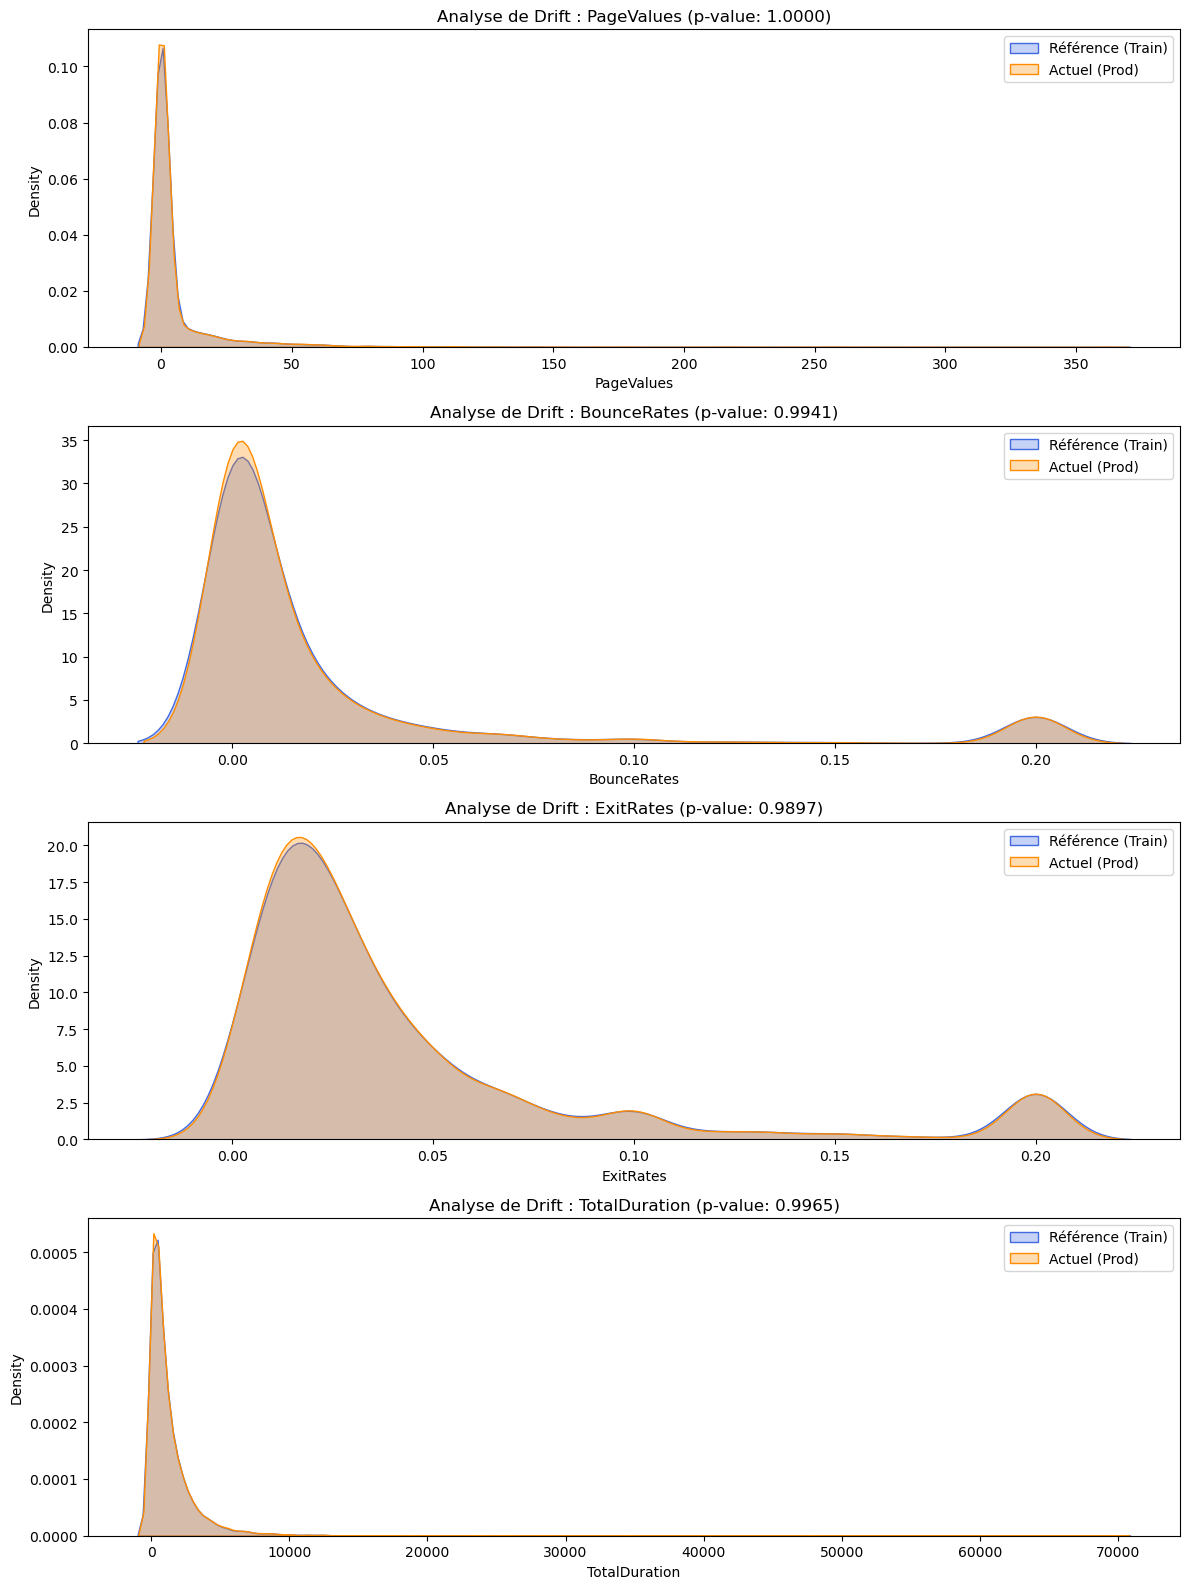

In [2]:
#  ÉTAPE 2 : CHARGEMENT DES DONNÉES SPARK 
try:
    print(" Chargement des tables Spark...")
    # Référence : ce que le modèle a appris (établi dans le NB 04)
    df_ref_spark = spark.read.table("gold.model_training_reference")
    # Actuel : les données qui viennent d'arriver aujourd'hui
    df_cur_spark = spark.read.table("gold.features_shopping")

    # Petit audit rapide pour les logs
    print(f" Lignes en référence : {df_ref_spark.count()}")
    print(f" Lignes actuelles   : {df_cur_spark.count()}")

    # --- ÉTAPE 3 : CONVERSION EN PANDAS POUR ANALYSE STATISTIQUE ---
    # On ne garde que les colonnes nécessaires pour optimiser la mémoire
    df_ref = df_ref_spark.select(columns_to_check).toPandas()
    df_cur = df_cur_spark.select(columns_to_check).toPandas()

    # --- ÉTAPE 4 : CALCUL DU DRIFT ET GÉNÉRATION DES GRAPHIQUES ---
    available_cols = [c for c in columns_to_check if c in df_ref.columns]
    
    # Préparation de la figure (1 ligne par colonne)
    plt.figure(figsize=(12, 4 * len(available_cols)))

    for i, col in enumerate(available_cols):
        # Test de Kolmogorov-Smirnov
        stat, p_value = ks_2samp(df_ref[col], df_cur[col])
        is_drifted = p_value < alpha
        
        if is_drifted:
            critical_drift = True
        
        # Affichage du statut dans les logs
        status = "⚠️ DRIFT" if is_drifted else "✅ OK"
        print(f"{status} | Colonne: {col:15} | p-value: {p_value:.4f}")

        # Visualisation des densités
        plt.subplot(len(available_cols), 1, i + 1)
        sns.kdeplot(df_ref[col], color="royalblue", label="Référence (Train)", fill=True, alpha=0.3)
        sns.kdeplot(df_cur[col], color="darkorange", label="Actuel (Prod)", fill=True, alpha=0.3)
        plt.title(f"Analyse de Drift : {col} (p-value: {p_value:.4f})")
        plt.legend()

    plt.tight_layout()
    plt.show()

# ÉTAPE 5 : GESTION DES ERREURS 
except Exception as e:
    print(f" ERREUR CRITIQUE lors du chargement ou de l'analyse : {str(e)}")
    # On arrête le pipeline avec un message d'erreur
    mssparkutils.notebook.exit("Error: " + str(e))

In [3]:
#3. Conclusion pour le pipeline
if critical_drift:
    print("\n🚨 Action requise : Un ré-entraînement est fortement conseillé.")
else:
    print("\n🟢 Tout est normal : Le modèle est toujours adapté aux données actuelles.")

StatementMeta(, 865c6b87-5278-4aa9-b021-5dfdf6762de8, 5, Finished, Available, Finished)


🟢 Tout est normal : Le modèle est toujours adapté aux données actuelles.


In [4]:
#  Sortie pour le pipeline Fabric
# On peut enregistrer le résultat pour que le pipeline sache quoi faire
mssparkutils.notebook.exit(str(critical_drift))

StatementMeta(, 865c6b87-5278-4aa9-b021-5dfdf6762de8, 6, Finished, Available, Finished)

ExitValue: False